<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Authors: [Yury Kashnitskiy](https://yorko.github.io) (@yorko), Yury Isakov. Edited by Anna Tarelina (@feuerengel), and Kolchenko Sergey (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #2. Spring 2019
## <center>  Competition 1. User Identification with Logistic Regression <br>(beating baselines in the "Alice" competition)

    
Today we are going to practice working with sparse matrices, training Logistic Regression models, and doing feature engineering. We will reproduce a couple of baselines in the  Kaggle Inclass competition ["Catch Me If You Can: Intruder Detection through Webpage Session Tracking"](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) (a.k.a. "Alice"). More credits will be given for beating stronger baselines. 

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) (basics of machine learning are covered here)
 2. Linear classification and regression in 5 parts: 
    - [ordinary least squares](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-1-ols)
    - [linear classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification)
    - [regularization](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-3-regularization)
    - [logistic regression: pros and cons](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit)
    - [validation](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-5-validation)
 3. You can also practice with demo assignments, which are simpler and already shared with solutions: 
    - " Sarcasm detection with logistic regression": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution)
    - "Linear regression as optimization": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-linear-regression-as-optimization/edit) (solution cannot be officially shared)
    - "Exploring OLS, Lasso and Random Forest in a regression task": [assignment](https://www.kaggle.com/kashnitsky/a6-demo-linear-models-and-rf-for-regression) + [solution](https://www.kaggle.com/kashnitsky/a6-demo-regression-solution)
 4. Alice baseline with logistic regression and "bag of sites", [Kernel](https://www.kaggle.com/kashnitsky/alice-logistic-regression-baseline)
 5. Correct time-aware cross-validation scheme, more features, and hyperparameter optimization, [Kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme)
 6. Other [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) in this competition. You can share yours as well, but not high-performing ones (Public LB MAE shall be < 0.95). Please don't spoil the competitive spirit. 
 7. If that's still not enough, watch two videos on logistic regression: [mlcourse.ai/video](https://mlcourse.ai/video)

**Your task:**
 1. "Follow me". Complete the missing code and submit your answers via [the google form](https://docs.google.com/forms/d/15PVw9CYlX6QnxRHKIDS161kGAq3v7iiO15W3qKTePEY). Use **the same email** as in A1 (for newcomers: remember your email and use it for all forms during the course). 12 credits max. for this part
 2. "Freeride". Come up with good features to beat the baselines "A2 baseline (10 credits)" and "A2 strong baseline (20 credits)". As names suggest, you'll get 10 more credits for beating the first one, and 10 more (20 in total) for beating the second one. You need to name your [team](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/team) (out of 1 person) in full accordance with the [course rating](https://docs.google.com/spreadsheets/d/1LAy1eK8vIONzIWgcCEaVmhKPSj579zK5lrECf_tQT60/edit?usp=sharing) (for newcomers: you need to name your team with your real full name). You can think of it as a part of the assignment.
 3. If you've beaten "A2 baseline (10 credits)" or performed better, you need to upload your solution as described in [course roadmap](https://mlcourse.ai/roadmap) ("Kaggle Inclass Competition Alice" -> Rules). For all baselines that you see on Public Leaderboard, it's OK to beat them on Public LB as well. But 10 winners will be defined according to the private LB, which will be revealed by @yorko on March 11. 
 
 ### <center> Deadline for A2: 2019 March 10, 20:59 GMT (London time)

In [2]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
sns.set()

In [3]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Now let us look at the timestamps and try to characterize sessions as timeframes:

In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [5]:
# Our target variable
y_train = train_df['target']

orig_train = train_df

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [6]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


## Let us remove the www. in url and regenerate our data

In [7]:
def inverse_dict(sites_dict):
    '''
    Gets a key-value dictionary. 
    Returns the dictionary by swapping the key and value.
    '''
    code_sites_dict = {}
    sites = list(sites_dict.items())
    for site in sites:
        code_sites_dict[site[1]] = site[0]
    return code_sites_dict

def get_sites_dict_(data):
    '''
    Gets dataframe with site names (10 columns) as input.
    Returns a dictionary of sites ordered by frequency.
    '''
    m, n = data.shape #num of rows and columns
    data = pd.DataFrame(data.values.reshape(m*n, 1), columns=['site']) #transform to 1 column
    freq = data.site.value_counts().reset_index()
    key_value_df = pd.DataFrame() #contains a pair of site-frequency
    key_value_df['site'] = freq['index']
    key_value_df['count'] = freq['site']
    key_value_df.sort_values(by='count', inplace=True, ascending=False) 
    sites_dict = {} 
    sites_dict['Unknown'] = 0
    for i in np.arange(key_value_df.shape[0]):
        if key_value_df.iloc[i,0]!='Unknown':
            sites_dict[key_value_df.iloc[i,0]] = i+1
    return sites_dict


In [8]:
import re
general_sites = full_sites[sites].apply(lambda ts: ts.map(inverse_dict(site_dict))) #instead of numbers the names of sites
general_sites = general_sites.fillna('Unknown')
general_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
54843,safebrowsing.clients.google.com,safebrowsing-cache.google.com,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
77292,www.apache.org,www.apache.org,download.eclipse.org,www.apache.org,www.apache.org,www.webtide.com,download.oracle.com,javadl-esd-secure.oracle.com,www.caucho.com,www.apache.org
114021,www.webtide.com,download.oracle.com,www.caucho.com,download.oracle.com,www.webtide.com,www.apache.org,public.dhe.ibm.com,www.webtide.com,www.apache.org,www.apache.org
146670,public.dhe.ibm.com,jope.ow2.org,download.oracle.com,public.dhe.ibm.com,jope.ow2.org,master.dl.sourceforge.net,www.apache.org,download.eclipse.org,www.apache.org,public.dhe.ibm.com


In [9]:
general_sites = general_sites.applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 
general_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
54843,safebrowsing.clients.google.com,safebrowsing-cache.google.com,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
77292,apache.org,apache.org,download.eclipse.org,apache.org,apache.org,webtide.com,download.oracle.com,javadl-esd-secure.oracle.com,caucho.com,apache.org
114021,webtide.com,download.oracle.com,caucho.com,download.oracle.com,webtide.com,apache.org,public.dhe.ibm.com,webtide.com,apache.org,apache.org
146670,public.dhe.ibm.com,jope.ow2.org,download.oracle.com,public.dhe.ibm.com,jope.ow2.org,master.dl.sourceforge.net,apache.org,download.eclipse.org,apache.org,public.dhe.ibm.com


In [10]:
new_site_dict = get_sites_dict_(general_sites)

#on a thousand unique sites became less.
print(len(list(site_dict.keys())), len(list(new_site_dict.keys())))

48371 47135


In [11]:
full_df[sites] = general_sites.apply(lambda ts: ts.map(new_site_dict)) #new coding

full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,30,14,0,0,0,0,0,0,0,0
54843,30,14,30,14,0,0,0,0,0,0
77292,474,474,529,474,474,1544,126,66,3280,474
114021,1544,126,3280,126,1544,474,820,1544,474,474
146670,820,2792,126,820,2792,3077,474,529,474,820


In [12]:
train_df.shape, test_df.shape, full_df.shape, full_sites.shape, y_train.shape, full_df.shape

((253561, 21),
 (82797, 20),
 (336358, 20),
 (336358, 10),
 (253561,),
 (336358, 20))

## We will remove outliers in data ie those sessions which lasted over 750 seconds

In [13]:
# Create a separate dataframe where we will work with timestamps
#time_df = pd.DataFrame(index=train_df.index)
#time_df['target'] = train_df['target']

# Find sessions' starting and ending
full_df['min'] = full_df[times].min(axis=1)
full_df['max'] = full_df[times].max(axis=1)

# Calculate sessions' duration in seconds
full_df['duration'] = (full_df['max'] - full_df['min']) / np.timedelta64(1, 's')
full_df = full_df.drop(columns=['min','max'])
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,duration
session_id,,,,,,,,,,,,,,,,,,,,,
21669,30,2013-01-12 08:05:57,14,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0.0
54843,30,2013-01-12 08:37:23,14,2013-01-12 08:37:23,30,2013-01-12 09:07:07,14,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,1786.0
77292,474,2013-01-12 08:50:13,474,2013-01-12 08:50:14,529,2013-01-12 08:50:15,474,2013-01-12 08:50:15,474,2013-01-12 08:50:16,...,2013-01-12 08:50:16,126,2013-01-12 08:50:16,66,2013-01-12 08:50:16,3280,2013-01-12 08:50:17,474,2013-01-12 08:50:17,4.0
114021,1544,2013-01-12 08:50:17,126,2013-01-12 08:50:17,3280,2013-01-12 08:50:18,126,2013-01-12 08:50:18,1544,2013-01-12 08:50:18,...,2013-01-12 08:50:18,820,2013-01-12 08:50:19,1544,2013-01-12 08:50:19,474,2013-01-12 08:50:19,474,2013-01-12 08:50:20,3.0
146670,820,2013-01-12 08:50:20,2792,2013-01-12 08:50:20,126,2013-01-12 08:50:20,820,2013-01-12 08:50:21,2792,2013-01-12 08:50:21,...,2013-01-12 08:50:21,474,2013-01-12 08:50:21,529,2013-01-12 08:50:22,474,2013-01-12 08:50:22,820,2013-01-12 08:50:22,2.0


In [14]:
train_df = full_df.iloc[0:idx_split]
test_df = full_df[idx_split:full_df.shape[0]]

In [15]:
train_df['target'] = y_train

C:\Users\sita\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
#train_df = train_df[train_df.duration<750]
#test_df = test_df[test_df.duration<750]

In [17]:
y_train = train_df['target']
train_df = train_df.drop(columns='target')

In [18]:
train_df.shape, test_df.shape, full_df.shape, full_sites.shape, y_train.shape, full_df.shape

((253561, 21),
 (82797, 21),
 (336358, 21),
 (336358, 10),
 (253561,),
 (336358, 21))

In [19]:
full_df = pd.concat([train_df, test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]
full_sites = full_df[sites]

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

Sessions are sequences of website indices, and data in this representation is useless for machine learning method (just think, what happens if we switched all ids of all websites). 

According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so each website has a corresponding feature (column) and its value is equal to number of this website visits in the session. It can be done in two lines:

In [20]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [21]:
full_sites_sparse.shape

(336358, 47135)

In [22]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [23]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9184945612268065
Wall time: 9.09 s


The first model demonstrated the quality  of 0.92 on the validation set. Let's take it as the first baseline and starting point. To make a prediction on the test data set **we need to train the model again on the entire training data set** (until this moment, our model used only part of the data for training), which will increase its generalizing ability:

In [24]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [25]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,duration
session_id,,,,,,,,,,,,,,,,,,,,,
21669,30,2013-01-12 08:05:57,14,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0.0
54843,30,2013-01-12 08:37:23,14,2013-01-12 08:37:23,30,2013-01-12 09:07:07,14,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,1786.0
77292,474,2013-01-12 08:50:13,474,2013-01-12 08:50:14,529,2013-01-12 08:50:15,474,2013-01-12 08:50:15,474,2013-01-12 08:50:16,...,2013-01-12 08:50:16,126,2013-01-12 08:50:16,66,2013-01-12 08:50:16,3280,2013-01-12 08:50:17,474,2013-01-12 08:50:17,4.0
114021,1544,2013-01-12 08:50:17,126,2013-01-12 08:50:17,3280,2013-01-12 08:50:18,126,2013-01-12 08:50:18,1544,2013-01-12 08:50:18,...,2013-01-12 08:50:18,820,2013-01-12 08:50:19,1544,2013-01-12 08:50:19,474,2013-01-12 08:50:19,474,2013-01-12 08:50:20,3.0
146670,820,2013-01-12 08:50:20,2792,2013-01-12 08:50:20,126,2013-01-12 08:50:20,820,2013-01-12 08:50:21,2792,2013-01-12 08:50:21,...,2013-01-12 08:50:21,474,2013-01-12 08:50:21,529,2013-01-12 08:50:22,474,2013-01-12 08:50:22,820,2013-01-12 08:50:22,2.0


In [58]:
# Compose the training set
#full_new_feat['start_hour'] =  pd.DatetimeIndex(full_df['time1']).hour
hour = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat = pd.DataFrame()
full_new_feat['start_hour'] = hour
full_new_feat['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
full_new_feat['afternoon'] = ((hour >= 12) & (hour <= 18)).astype('int')
full_new_feat['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
full_new_feat['night'] = ((hour >= 0) & (hour <= 6)).astype('int')
full_new_feat['n_unique_sites'] = full_df[sites].nunique(axis=1)
full_new_feat['sitescount'] = full_df[sites].gt(0).sum(axis=1)
full_new_feat['dayofweek'] = full_df['time1'].apply(lambda ts: ts.dayofweek)
full_new_feat['duration'] = full_df['duration']
full_new_feat = full_new_feat.drop(columns=['start_hour','night'])

In [59]:
full_new_feat.iloc[1000:1010]

,morning,afternoon,evening,n_unique_sites,sitescount,dayofweek,duration
session_id,,,,,,,
104848,1,0,0,7,10,1,3.0
135931,1,0,0,6,10,1,24.0
156213,1,0,0,5,10,1,3.0
85563,1,0,0,9,10,1,4.0
55492,1,0,0,7,10,1,4.0
240203,1,0,0,4,10,1,86.0
240093,1,0,0,2,10,1,7.0
17894,1,0,0,6,10,1,7.0
223420,1,0,0,9,10,1,6.0


tmp_scaled = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

In [31]:
X_train.shape, X_test.shape

((253561, 47143), (82797, 47143))

In [32]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

# Train the model on the whole training data set using optimal regularization parameter
C = 1.0
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lr_csr.csv') # gave 0.92352

## Let us try with count vec of the sites.

In [34]:
train_df = full_df.iloc[0:idx_split]
test_df = full_df[idx_split:full_df.shape[0]]

In [60]:
training_full = full_new_feat[0:idx_split]
training_full['target'] = y_train

C:\Users\sita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
training_full.head()

,morning,afternoon,evening,n_unique_sites,sitescount,dayofweek,duration,target
session_id,,,,,,,,
21669,1,0,0,3,2,5,0.0,0
54843,1,0,0,3,4,5,1786.0,0
77292,1,0,0,6,10,5,4.0,0
114021,1,0,0,5,10,5,3.0,0
146670,1,0,0,6,10,5,2.0,0


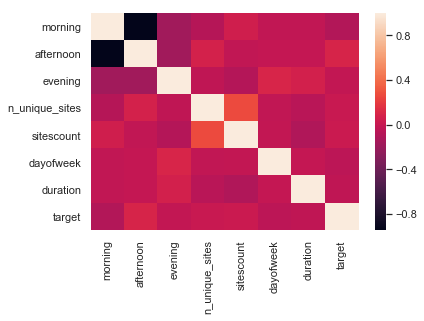

In [62]:
sns.heatmap(training_full.corr())

In [35]:
train_df.shape, test_df.shape, y_train.shape

((253561, 21), (82797, 21), (253561,))

In [36]:
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 3), max_features=75000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_cv = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_cv = cv.transform(inp_test_file)
X_train_cv.shape, X_test_cv.shape

((253561, 75000), (82797, 75000))

In [63]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat)
X_train_new = hstack([X_train_cv, tmp_scaled[:idx_split,:]])
X_test_new = hstack([X_test_cv, tmp_scaled[idx_split:,:]])


In [64]:
# Train the model on the whole training data set using optimal regularization parameter
#C = 1.0 
C = 0.0774263682681127 #obtained with gridsearchcv
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train_new, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lr_countvec.csv') # 0.92488, 0.93751 with dayofweek added, 0.93802 with duration added
# 0.94889 dropped start_hour and night

In [65]:
*************

SyntaxError: invalid syntax (<ipython-input-65-07f3fcc11938>, line 1)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

logit = LogisticRegression(random_state=17, class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-2, 2, 10)

In [ ]:
from sklearn.model_selection import cross_val_score

logit_cv = GridSearchCV(estimator=logit, param_grid={'C': c_values}, scoring='roc_auc', cv=skf, verbose=1)

In [ ]:
logit_cv.fit(X_train_new, y_train)
logit_cv.score
logit_cv.best_estimator_, logit_cv.best_params_, logit_cv.best_score_

In [ ]:
# with the csr data
logit_cv2 = GridSearchCV(estimator=logit, param_grid={'C': c_values}, scoring='roc_auc', cv=skf, verbose=1)
logit_cv2.fit(X_train, y_train)
logit_cv2.score
logit_cv2.best_estimator_, logit_cv2.best_params_, logit_cv2.best_score_

In [ ]:
# Make a prediction for the test set
y_test = logit_cv.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lr_cv_countvec.csv') #score 0.90856 (sparse), 0.92765 (count vec), 0.92518 (countvec 75000)

In [ ]:
************

In [66]:
from sklearn.model_selection import train_test_split

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train_new, y_train, 
                     test_size=0.2, random_state=17)

In [68]:
from lightgbm import LGBMClassifier
lgbm5 = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=-1, num_leaves=5, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm5.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm5.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.9438188185603609


In [69]:
lgbm5.fit(X_train_new, y_train)
y_test = lgbm5.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lgbm.csv')

C:\Users\sita\Anaconda3\lib\site-packages\lightgbm\basic.py:469: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


## Score was 0.92339, roc auc = 0.9438188185603609

In [ ]:
parameters = {'num_leaves': [7, 15, 31, 63, 127, 255],
              'max_depth': [3, 4, 5, 6]}
grid_search = GridSearchCV(estimator=lgbm5, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=5)
grid_search = grid_search.fit(X_train_new, y_train)

In [ ]:
grid_search.best_params_, grid_search.best_score_

In [ ]:
grid_search.best_estimator_

In [70]:
lgbm6 = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=6, num_leaves=15, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm6.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm6.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.9318559238352175


In [71]:
lgbm6.fit(X_train_new, y_train)
y_test = lgbm6.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lgbm6.csv')

C:\Users\sita\Anaconda3\lib\site-packages\lightgbm\basic.py:469: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


## Score = 

In [72]:
xgb = XGBClassifier(seed=17)
xgb.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.955211339578915

In [73]:
xgb.fit(X_train_new, y_train)
y_test = xgb.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb.csv')

## Score = , roc auc = 0.955211339578915, let us fine tune parameters

In [ ]:
xgb

In [ ]:
from sklearn.model_selection import train_test_split
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train_new, y_train, 
                     test_size=0.2, random_state=17)

In [74]:
xgb = XGBClassifier(seed=17, n_estimators=500)
xgb.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.9728905221061348

In [75]:
xgb.fit(X_train_new, y_train)
y_test = xgb.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb2.csv') 

## Score = 0.94721, roc auc = 0.9728905221061348

In [ ]:
parameters = {'num_leaves': [7, 15, 31, 63, 127, 255],
              'max_depth': [3, 4, 5, 6]}
grid_search2 = GridSearchCV(estimator=xgb, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=5)
grid_search2 = grid_search2.fit(X_train, y_train)

In [ ]:
grid_search2.best_params_, grid_search2.best_score_

In [ ]:
grid_search2.best_estimator_

In [ ]:
xgb3 = XGBClassifier(seed=17, n_estimators=500, max_depth=6, num_leaves=15)
xgb3.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb3.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

In [ ]:
xgb3.fit(X_train, y_train)
y_test = xgb3.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb3.csv')

## Score = 0.90039

In [ ]:
p1 = pd.read_csv('xgb2.csv')
p2 = pd.read_csv('countvec_lr_cv.csv')

In [ ]:
p1.columns

In [ ]:
p3 = 0.4*p1['target'] + 0.6*p2['target']

In [ ]:
p3.head()

In [ ]:
p3.index += 1

In [ ]:
pd.Series(p3, name='target').to_csv('p3.csv', index_label='session_id', header=True)

## Score = 0.92685

In [ ]:
p4 = 0.2*p1['target'] + 0.8*p2['target']

In [ ]:
p4.index += 1

In [ ]:
pd.Series(p4, name='target').to_csv('p8.csv', index_label='session_id', header=True) #lr_cv countvec with xgb2 stacked 0.93419

## Score = 0.92865

## New score = 0.92444

## After adding all features : 0.92548

In [ ]:
p1 = pd.read_csv('xgb2.csv')
p2 = pd.read_csv('lgbm.csv')

In [ ]:
p5 = 0.6*p1['target'] + 0.4*p2['target']
p5.index += 1
pd.Series(p5, name='target').to_csv('p5.csv', index_label='session_id', header=True)

## Score = 0.90100